<a href="https://colab.research.google.com/github/cyyeh/ds-portfolios/blob/master/projects/youbike/notebooks/1.0-youbike-history-data-eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Youbike History Data EDA

reference: https://github.com/pixnet/2018-pixnet-hackathon/blob/master/opendata/pmo.opendata.md

- youbike station vacancy data
- from: 2018/1/1
- to: 2018/6/15
- update frequency: 5 minute

In [22]:
# install chinese font
!wget https://noto-website-2.storage.googleapis.com/pkgs/NotoSerifCJKtc-hinted.zip
!unzip NotoSerifCJKtc-hinted.zip
!mv NotoSerifCJKtc-Medium.otf /usr/share/fonts/truetype/

--2020-03-11 01:54:52--  https://noto-website-2.storage.googleapis.com/pkgs/NotoSerifCJKtc-hinted.zip
Resolving noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)... 172.217.204.128, 2607:f8b0:400c:c15::80
Connecting to noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)|172.217.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 130464138 (124M) [application/zip]
Saving to: ‘NotoSerifCJKtc-hinted.zip’

NotoSerifCJKtc-hint 100%[===================>] 124.42M   154MB/s    in 0.8s    

2020-03-11 01:54:53 (154 MB/s) - ‘NotoSerifCJKtc-hinted.zip’ saved [130464138/130464138]

Archive:  NotoSerifCJKtc-hinted.zip
  inflating: LICENSE_OFL.txt         
  inflating: NotoSerifCJKtc-Black.otf  
  inflating: NotoSerifCJKtc-Bold.otf  
  inflating: NotoSerifCJKtc-ExtraLight.otf  
  inflating: NotoSerifCJKtc-Light.otf  
  inflating: NotoSerifCJKtc-Medium.otf  
  inflating: NotoSerifCJKtc-Regular.otf  
  inflating: NotoS

## Get Data

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_path = '/usr/share/fonts/truetype/NotoSerifCJKtc-Medium.otf'
font_prop = fm.FontProperties(fname=font_path, size=15)

import warnings
warnings.filterwarnings("ignore")

In [0]:
def get_youbike_history_data(stop_no=None):
  FILE_PATHS = [
    'drive/My Drive/youbike-history-data-1.csv.zip',
    'drive/My Drive/youbike-history-data-2.csv.zip'
  ]

  FIELDS_LIST = [
    'stop_no', 
    'stop_name', 
    'total_number', 
    'current_number', 
    'stop_area', 
    'update_time', 
    'lat', 
    'lng', 
    'address', 
    'stop_area_en', 
    'stop_name_en',
    'address_en',
    'vacancy_number',
    'status',
    'batch_update_time',
    'db_update_time',
    'update_info_time',
    'update_info_date'
  ]

  FIELDS_TO_KEEP = [
      'stop_no',
      'stop_name',
      'stop_area',
      'lat',
      'lng',
      'total_number',
      'current_number',
      'vacancy_number',
      'status',
      'db_update_time'
  ]

  read_csv_func = partial(pd.read_csv, names=FIELDS_LIST)
  df = pd.concat(map(read_csv_func, FILE_PATHS), sort=True)
  df = df[FIELDS_TO_KEEP]
  df['db_update_time'] = pd.to_datetime(df['db_update_time'])
  df = df[df['status'] == 1] # enabled

  if stop_no:
    df = (df[df['stop_no'] == stop_no]
            .sort_values('db_update_time')
            .set_index('db_update_time'))
  else:
    df = (df.groupby('stop_no')
            .apply(pd.DataFrame.sort_values, 'db_update_time')
            .set_index(['stop_no', 'db_update_time']))

  return df

In [0]:
df = get_youbike_history_data(stop_no=186) #台北市立大學

## EDA

In [77]:
df.head()

,stop_no,stop_name,stop_area,lat,lng,total_number,current_number,vacancy_number,status
db_update_time,,,,,,,,,
2018-01-01 00:10:00,186,臺北市立大學,中正區,25.0354,121.514,82,29,53,1
2018-01-01 00:15:00,186,臺北市立大學,中正區,25.0354,121.514,82,29,53,1
2018-01-01 00:20:00,186,臺北市立大學,中正區,25.0354,121.514,82,30,52,1
2018-01-01 00:25:00,186,臺北市立大學,中正區,25.0354,121.514,82,24,58,1
2018-01-01 00:30:00,186,臺北市立大學,中正區,25.0354,121.514,82,23,59,1


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43788 entries, 2018-01-01 00:10:00 to 2018-06-16 00:00:00
Data columns (total 9 columns):
stop_no           43788 non-null int64
stop_name         43788 non-null object
stop_area         43788 non-null object
lat               43788 non-null object
lng               43788 non-null object
total_number      43788 non-null int64
current_number    43788 non-null int64
vacancy_number    43788 non-null int64
status            43788 non-null int64
dtypes: int64(5), object(4)
memory usage: 3.3+ MB


In [79]:
df['status'].value_counts()

1    43788
Name: status, dtype: int64

### Plot number of youbike available by month

In [81]:
df_M = df.resample('M').mean()
df_M

,stop_no,total_number,current_number,vacancy_number,status
db_update_time,,,,,
2018-01-31,186.0,82.0,33.885769,47.113462,1.0
2018-02-28,186.0,82.0,41.367859,39.930949,1.0
2018-03-31,186.0,82.0,28.940801,52.722482,1.0
2018-04-30,186.0,82.0,29.315752,52.334290,1.0
2018-05-31,186.0,82.0,27.954662,53.433627,1.0
2018-06-30,186.0,82.0,27.067603,54.604984,1.0


In [0]:
x = df_M.index
y = df_M.current_number

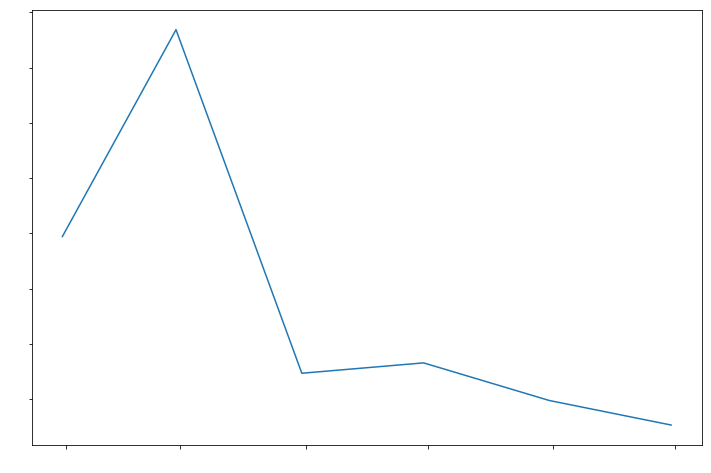

In [91]:
plt.figure(figsize=(12, 8))
plt.xticks(color='white', fontsize=14)
plt.yticks(color='white', fontsize=14)
plt.plot(x, y);

### Plot number of youbike available by day

In [95]:
df_D = df.resample('D').mean()
df_D

,stop_no,total_number,current_number,vacancy_number,status
db_update_time,,,,,
2018-01-01,186.0,82.0,16.380282,65.619718,1.0
2018-01-02,186.0,82.0,32.083333,49.545139,1.0
2018-01-03,186.0,82.0,21.181034,58.724138,1.0
2018-01-04,NaN,NaN,NaN,NaN,NaN
2018-01-05,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2018-06-12,186.0,82.0,25.753191,56.246809,1.0
2018-06-13,186.0,82.0,15.857639,65.628472,1.0
2018-06-14,186.0,82.0,26.191489,54.751773,1.0


In [0]:
x = df_D.index
y = df_D.current_number

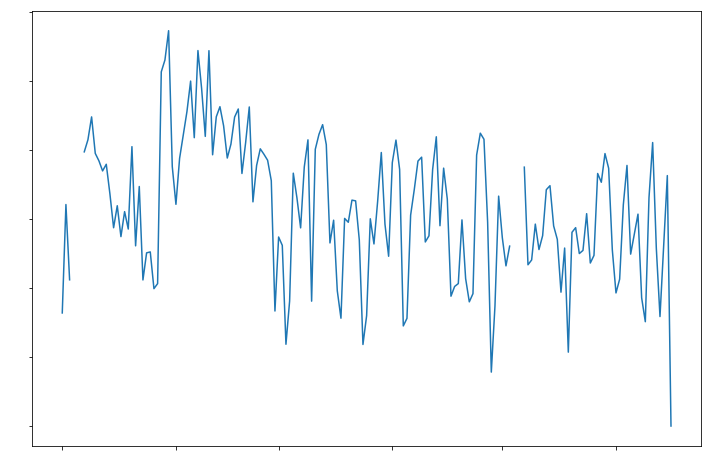

In [97]:
plt.figure(figsize=(12, 8))
plt.xticks(color='white', fontsize=14)
plt.yticks(color='white', fontsize=14)
plt.plot(x, y);

### Plot number of youbike available by hour

In [98]:
df_H = df.resample('H').mean()
df_H

,stop_no,total_number,current_number,vacancy_number,status
db_update_time,,,,,
2018-01-01 00:00:00,186.0,82.0,24.777778,57.222222,1.0
2018-01-01 01:00:00,186.0,82.0,10.416667,71.583333,1.0
2018-01-01 02:00:00,186.0,82.0,11.083333,70.916667,1.0
2018-01-01 03:00:00,186.0,82.0,12.750000,69.250000,1.0
2018-01-01 04:00:00,186.0,82.0,15.916667,66.083333,1.0
...,...,...,...,...,...
2018-06-15 20:00:00,186.0,82.0,10.000000,71.000000,1.0
2018-06-15 21:00:00,186.0,82.0,9.916667,71.083333,1.0
2018-06-15 22:00:00,186.0,82.0,10.333333,70.416667,1.0


In [0]:
x = df_H.index
y = df_H.current_number

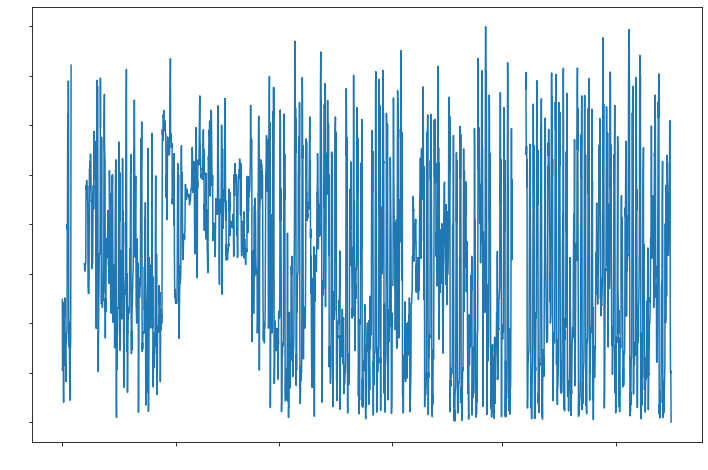

In [100]:
plt.figure(figsize=(12, 8))
plt.xticks(color='white', fontsize=14)
plt.yticks(color='white', fontsize=14)
plt.plot(x, y);